In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

plots = {}

In [12]:

folder_path = './Yolo_dataset' 
save_folder_path = folder_path + '/models/'
files = os.listdir(folder_path)
print(files)

['dataset3.csv', 'models', 'dataset4.csv', 'dataset1.csv', 'dataset2.csv']


In [5]:
df = pd.read_csv(folder_path+'/dataset3.csv')
df.shape

(63940, 40)

# Time series

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0]]
        y.append(label)
    return np.array(X), np.array(y)

window_size = 5
X, y = df_to_X_y(df, window_size)
X.shape, y.shape

((63935, 5, 40), (63935, 1))

In [7]:
total = len(X) 
split1 = int(total * 0.70)
split2 = split1 + int(total * 0.15)
X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((44754, 5, 40),
 (44754, 1),
 (9590, 5, 40),
 (9590, 1),
 (9591, 5, 40),
 (9591, 1))

In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np

nsamples, ntimesteps, nfeatures = X_train.shape
X_train_2d = X_train.reshape(-1, nfeatures)
X_val_2d   = X_val.reshape(-1, nfeatures)
X_test_2d  = X_test.reshape(-1, nfeatures)

scaler = StandardScaler()
scaler.fit(X_train_2d)

X_train_scaled = scaler.transform(X_train_2d).reshape(nsamples, ntimesteps, nfeatures)
X_val_scaled   = scaler.transform(X_val_2d).reshape(X_val.shape)
X_test_scaled  = scaler.transform(X_test_2d).reshape(X_test.shape)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled   = y_scaler.transform(y_val)
y_test_scaled  = y_scaler.transform(y_test)

In [ ]:
temp_training_mean = np.mean(X_train[:, :, 0])
temp_training_std = np.std(X_train[:, :, 0])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  #return X

print(temp_training_mean, temp_training_std)
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)

52.61819425482978 9.744592204331632


### CNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten

input_layer = Input(shape=(window_size, 40))

x = Conv1D(64, kernel_size=2)(input_layer)
x = Flatten()(x)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 4, 64)          │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,249 (28.32 KB)

 Trainable params: 7,249 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=15,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=64
)

Epoch 1/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.4759 - root_mean_squared_error: 0.6716 - val_loss: 0.3376 - val_root_mean_squared_error: 0.5810
Epoch 2/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0741 - root_mean_squared_error: 0.2718 - val_loss: 0.1358 - val_root_mean_squared_error: 0.3685
Epoch 3/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0440 - root_mean_squared_error: 0.2093 - val_loss: 0.1052 - val_root_mean_squared_error: 0.3243
Epoch 4/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0260 - root_mean_squared_error: 0.1610 - val_loss: 0.0599 - val_root_mean_squared_error: 0.2448
Epoch 5/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0182 - root_mean_squared_error: 0.1348 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2013
Epoch 6/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1974
Epoch 7/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

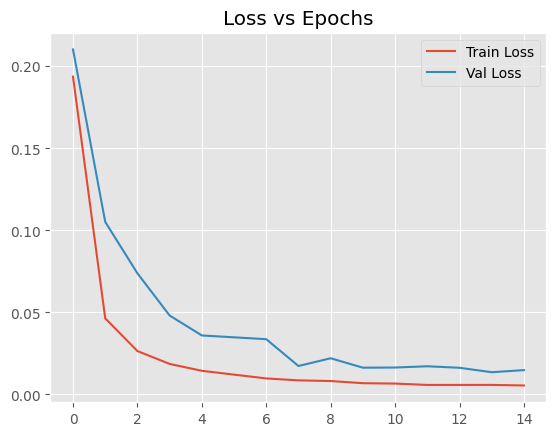

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


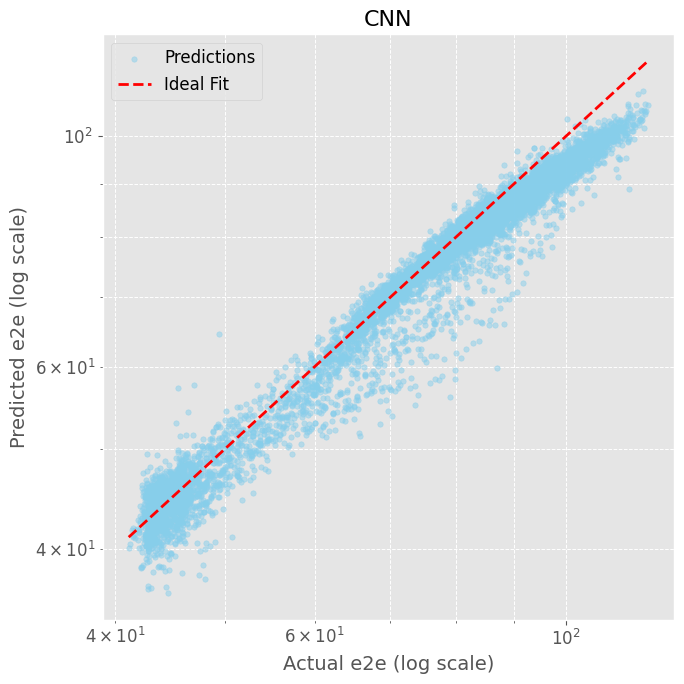

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("CNN")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots['CNN'] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.7093
MSE:  15.2630
RMSE: 3.9068
R²:   0.9572


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


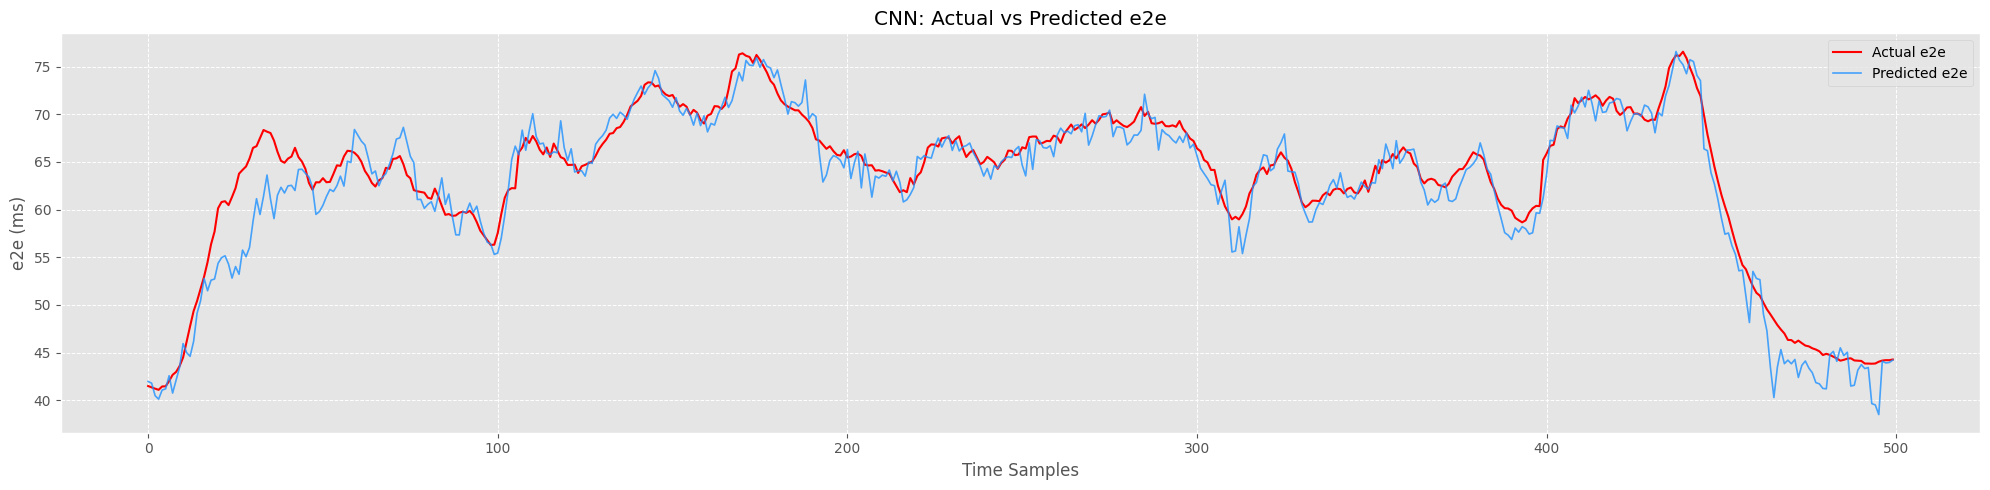

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("CNN: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


In [ ]:
model.save(save_folder_path + "TS_40F_CNN.keras")

In [ ]:
from tensorflow import keras
model = keras.models.load_model(save_folder_path + "TS_40F_CNN.keras")

### GRU

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D,  GRU
from tensorflow.keras.layers import MaxPooling1D, Dropout

input_layer = Input(shape=(window_size, 40))

x = GRU(64)(input_layer)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        20,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,881 (81.57 KB)

 Trainable params: 20,881 (81.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=15,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=64
)

Epoch 1/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.3465 - root_mean_squared_error: 0.5685 - val_loss: 1.5397 - val_root_mean_squared_error: 1.2409
Epoch 2/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0351 - root_mean_squared_error: 0.1871 - val_loss: 1.0132 - val_root_mean_squared_error: 1.0066
Epoch 3/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0188 - root_mean_squared_error: 0.1368 - val_loss: 0.8250 - val_root_mean_squared_error: 0.9083
Epoch 4/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0111 - root_mean_squared_error: 0.1053 - val_loss: 0.7280 - val_root_mean_squared_error: 0.8533
Epoch 5/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.6857 - val_root_mean_squared_error: 0.8281
Epoch 6/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.6220 - val_root_mean_squared_error: 0.7886
Epoch 7/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/st

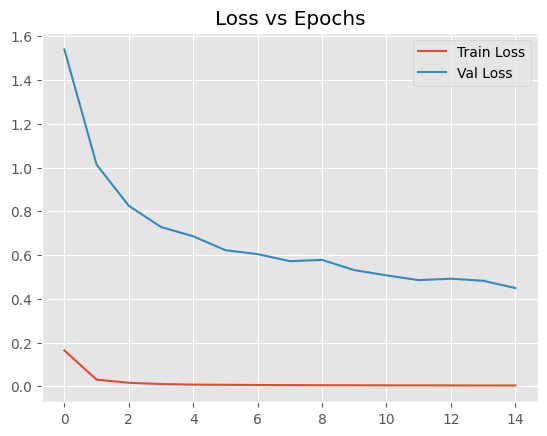

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
#load model
from tensorflow import keras

model = keras.models.load_model(save_folder_path + "TS_43F_GRU.keras")

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


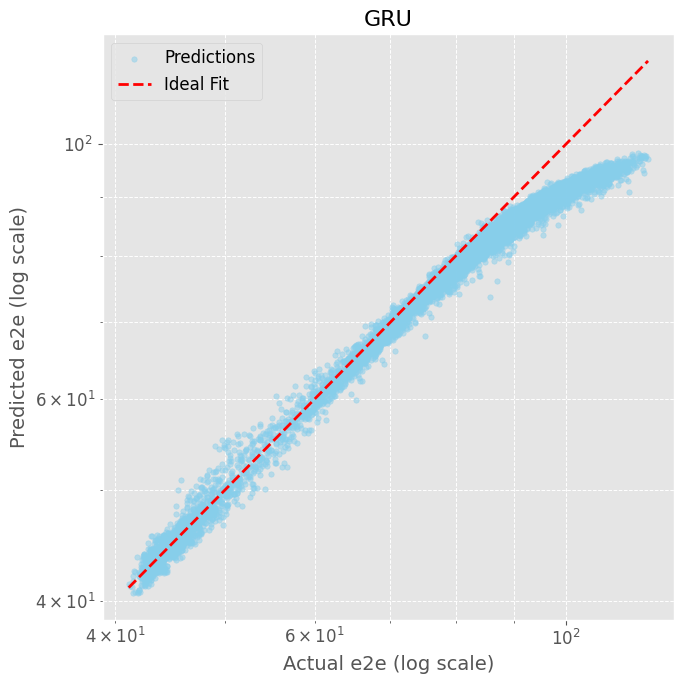

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("GRU")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["GRU"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  4.2073
MSE:  42.6387
RMSE: 6.5298
R²:   0.8805


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


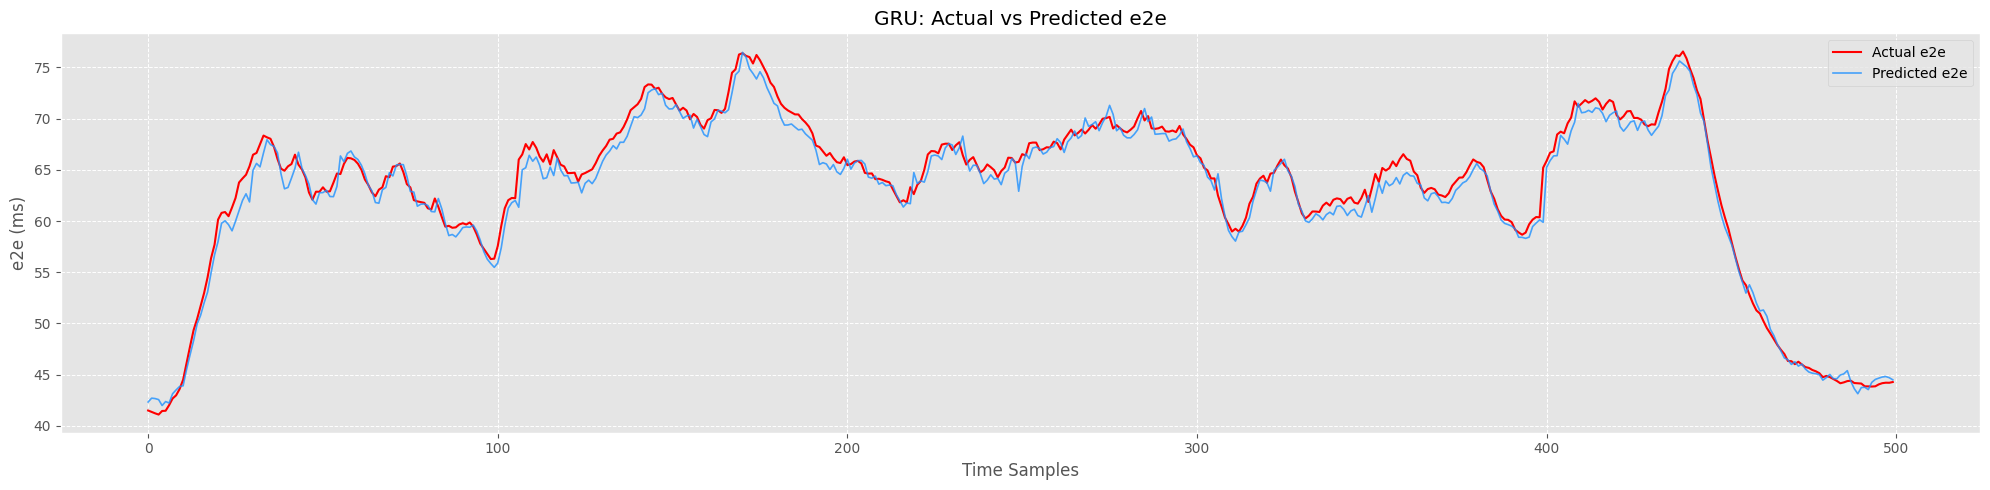

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("GRU: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


In [ ]:
model.save(save_folder_path + "TS_40F_GRU.keras")

### LSTM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
from tensorflow.keras.layers import MaxPooling1D, Dropout

input_layer = Input(shape=(window_size, 40))

x = LSTM(64)(input_layer)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,409 (107.07 KB)

 Trainable params: 27,409 (107.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=15,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=64
)

Epoch 1/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0033 - root_mean_squared_error: 0.0572 - val_loss: 0.2365 - val_root_mean_squared_error: 0.4863
Epoch 2/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0557 - val_loss: 0.2070 - val_root_mean_squared_error: 0.4550
Epoch 3/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 0.2302 - val_root_mean_squared_error: 0.4798
Epoch 4/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.2065 - val_root_mean_squared_error: 0.4544
Epoch 5/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0552 - val_loss: 0.2097 - val_root_mean_squared_error: 0.4580
Epoch 6/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.2020 - val_root_mean_squared_error: 0.4495
Epoch 7/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step 

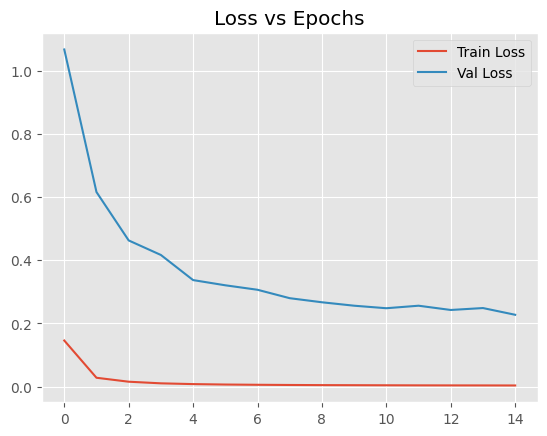

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


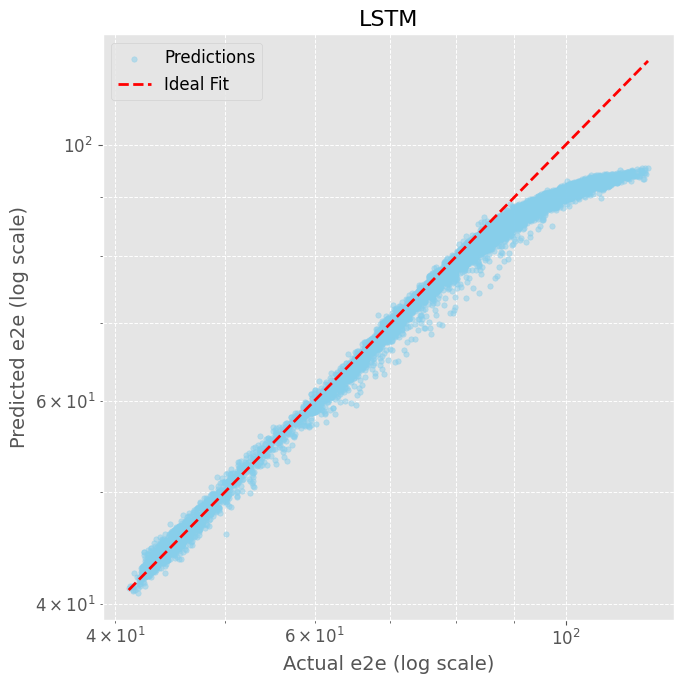

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)

y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("LSTM")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots['LSTM'] = (fig, ax)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  3.1422
MSE:  21.5650
RMSE: 4.6438
R²:   0.9396


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


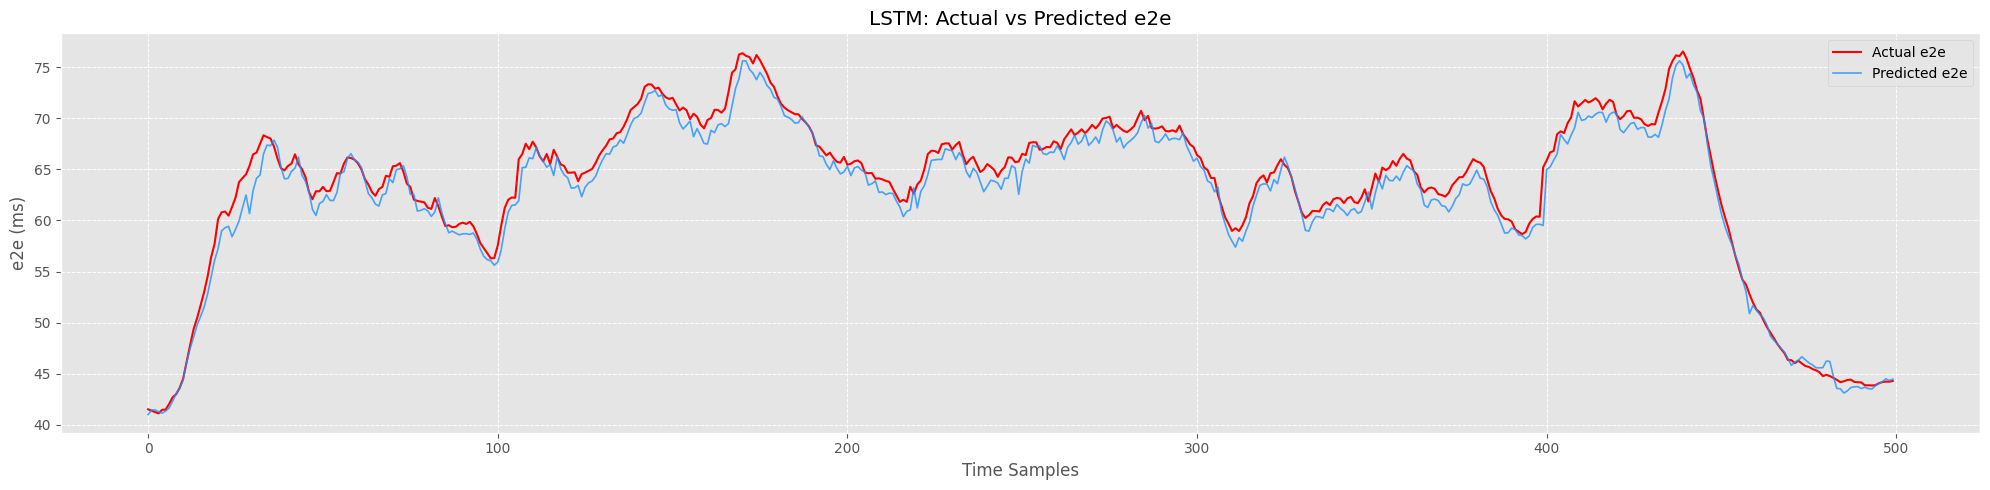

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
#zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("LSTM: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


In [ ]:
model.save(save_folder_path + "TS_40F_LSTM.keras")

In [ ]:
model = keras.models.load_model(save_folder_path + "TS_40F_LSTM.keras")

### CNN + LSTM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense

input_layer = Input(shape=(5, 40))

x = Conv1D(64, kernel_size=2, padding='same', activation='relu')(input_layer)
x = LSTM(64)(x)
x = Dense(8, activation='relu')(x)

e2e_output = Dense(1, activation='linear', name='e2e')(x)

model = Model(inputs=input_layer, outputs=e2e_output)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 5, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5, 64)          │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ e2e (Dense)                     │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,737 (151.32 KB)

 Trainable params: 38,737 (151.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'e2e': MeanSquaredError(),
        #'dropped': BinaryCrossentropy()
    },
    metrics={
        'e2e': [RootMeanSquaredError()],
        #'dropped': [Accuracy()]
    }
)

#checkpoint_path = os.path.join(new_folder, 'model_mul_lstm_epoch_{epoch}.keras')

# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=15,
    # callbacks=[checkpoint_cb, earlystop_cb],
    callbacks=[earlystop_cb],
    batch_size=64
)

Epoch 1/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.2361 - root_mean_squared_error: 0.4572 - val_loss: 0.6447 - val_root_mean_squared_error: 0.8029
Epoch 2/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.4410 - val_root_mean_squared_error: 0.6641
Epoch 3/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0101 - root_mean_squared_error: 0.1002 - val_loss: 0.3610 - val_root_mean_squared_error: 0.6009
Epoch 4/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.2981 - val_root_mean_squared_error: 0.5460
Epoch 5/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.2936 - val_root_mean_squared_error: 0.5418
Epoch 6/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.2744 - val_root_mean_squared_error: 0.5239
Epoch 7/15
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/s

In [14]:
from tensorflow import keras
model = keras.models.load_model(save_folder_path + "TS_40F_CNN_plus_LSTM.keras")

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


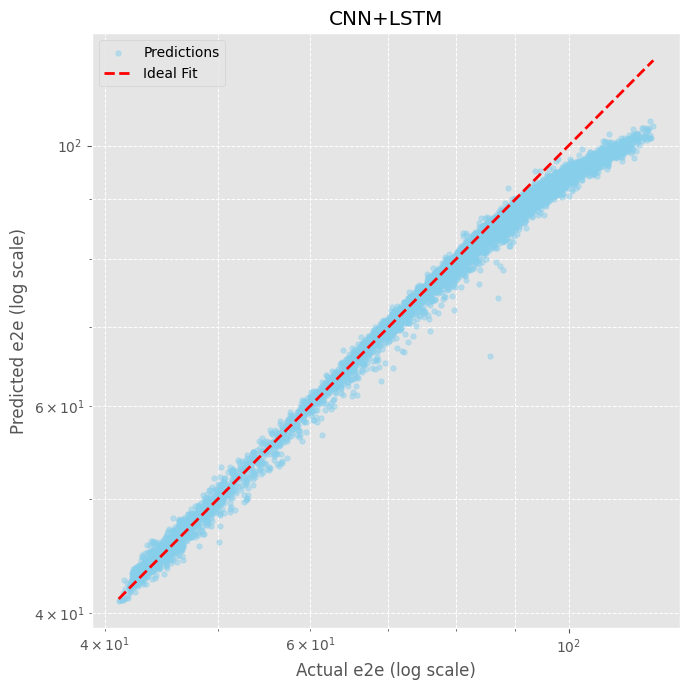

In [15]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred = model.predict(X_val_scaled)  

y_val_pred = y_scaler.inverse_transform(y_val_pred.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_pred.reshape(-1, 1))

# Optional zoom for plotting
# zoom = slice(1000, 1500)
zoom = slice(None)  
y_true_zoom = y_val[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
ax.plot([y_true_zoom.min(), y_true_zoom.max()],
        [y_true_zoom.min(), y_true_zoom.max()],
        "r--", linewidth=2, label="Ideal Fit")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Actual e2e (log scale)")
ax.set_ylabel("Predicted e2e (log scale)")
ax.set_title("CNN+LSTM")
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()

plots["CNN+LSTM"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.1265
MSE:  10.7547
RMSE: 3.2794
R²:   0.9699


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


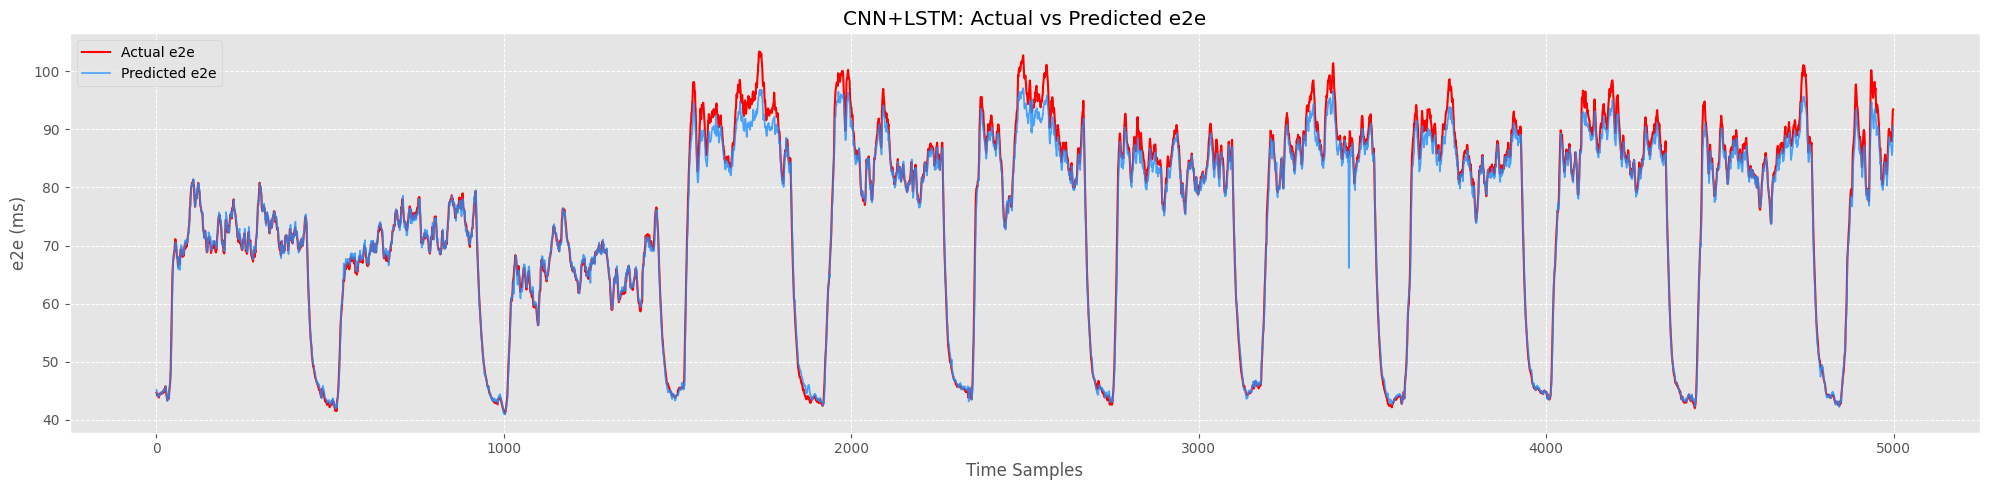

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(0, 5000)
#zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("CNN+LSTM: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


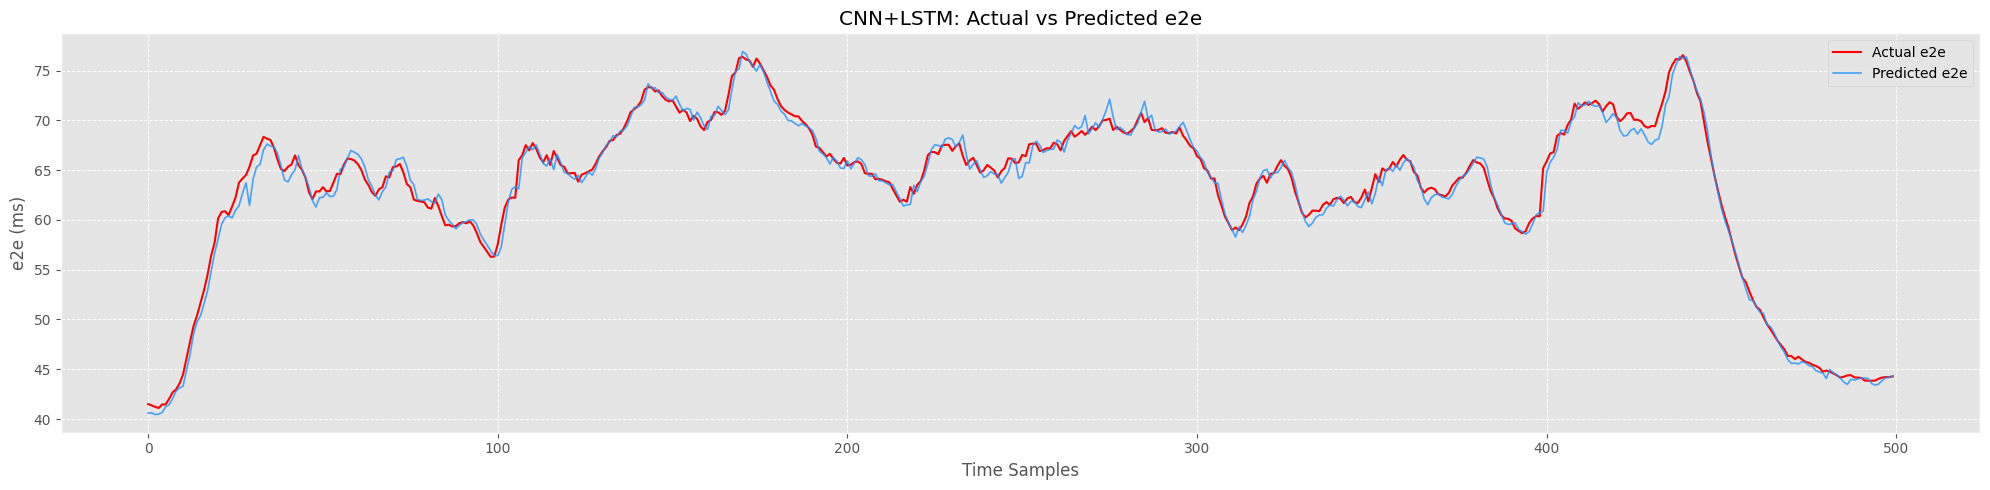

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("CNN+LSTM: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()

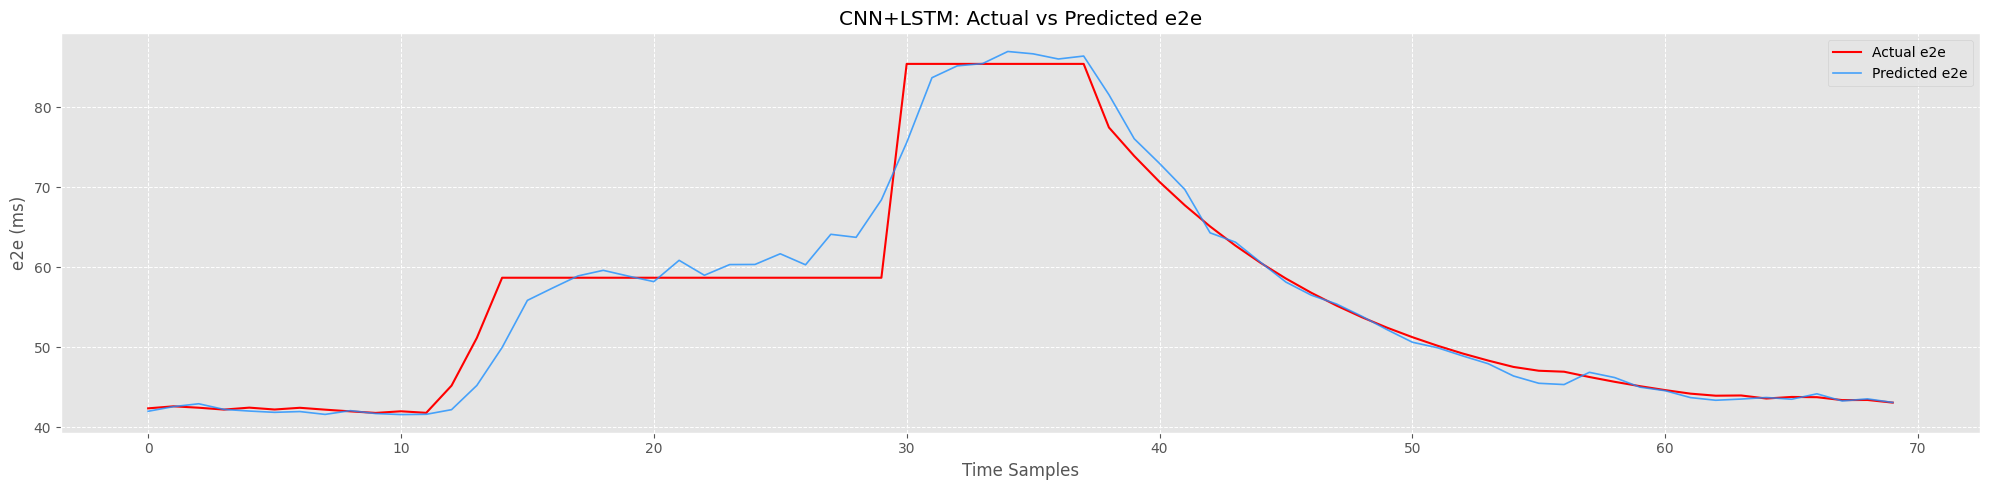

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#y_val_pred_scaled = model.predict(X_train_scaled)
#y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
#y_val_original = y_scaler.inverse_transform(y_train_scaled.reshape(-1, 1))

#zoom = slice(None)
zoom = slice(5180, 5250)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Time series plot
plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("CNN+LSTM: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()

# Regression

In [ ]:
def df_to_X_y(df, target_col="e2e"):
    X = df.drop(columns=[target_col]).to_numpy()
    y = df[target_col].to_numpy()
    return X, y

X, y = df_to_X_y(df)
print(X.shape, y.shape)

(63940, 42) (63940,)


In [ ]:
total = len(X)  # should be 27572
split1 = int(total * 0.70)
split2 = split1 + int(total * 0.15)
X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((44758, 42), (44758,), (9591, 42), (9591,), (9591, 42), (9591,))

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled   = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_scaled, y_train_scaled)
y_pred = reg.predict(X_test_scaled)

print("Coefficients:", reg.coef_)
print("Intercept:", reg.intercept_)


Coefficients: [ 8.80232273e-03 -1.75429777e-02  5.15081143e-02  9.11553305e-03
 -5.48344866e-04  3.94411466e-02  7.57258579e-02  2.27393298e-05
 -2.08511202e-02 -7.57660162e-03  3.41432304e-02 -6.87567954e-03
 -1.48428468e-03 -8.32977489e-03  6.73312914e-03 -1.35520081e-01
  6.39931997e-02  2.47880711e-02  1.08248526e-01  9.36673540e-03
 -1.89812719e-01 -6.92551133e-02 -5.59382174e-02 -5.47642634e-02
 -3.10500660e-02 -1.38786935e-01 -3.84757443e-02 -2.51072415e-02
 -4.76484827e-02 -8.71910335e-03 -4.90890031e-03 -9.55730223e-03
 -3.48624237e-02  9.44717440e-02 -3.69768110e-01 -9.43182018e-02
  7.01415354e-01 -1.24348674e+04  1.24348971e+04 -3.69658599e-03
 -1.57389261e-02 -5.76019229e-02]
Intercept: -1.0866092086904503e-11


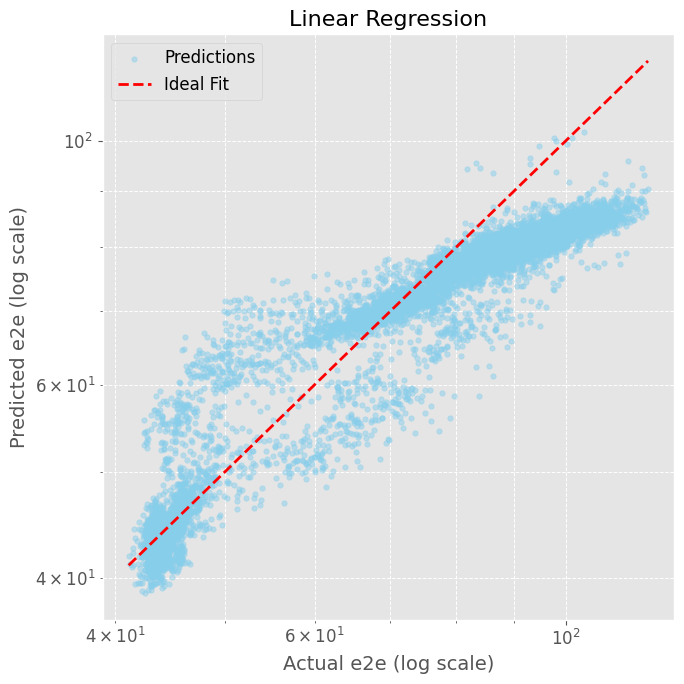

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = reg.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("Linear Regression")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()

fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["LinearReg"] = (fig, ax)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  8.1446
MSE:  105.1481
RMSE: 10.2542
R²:   0.7054


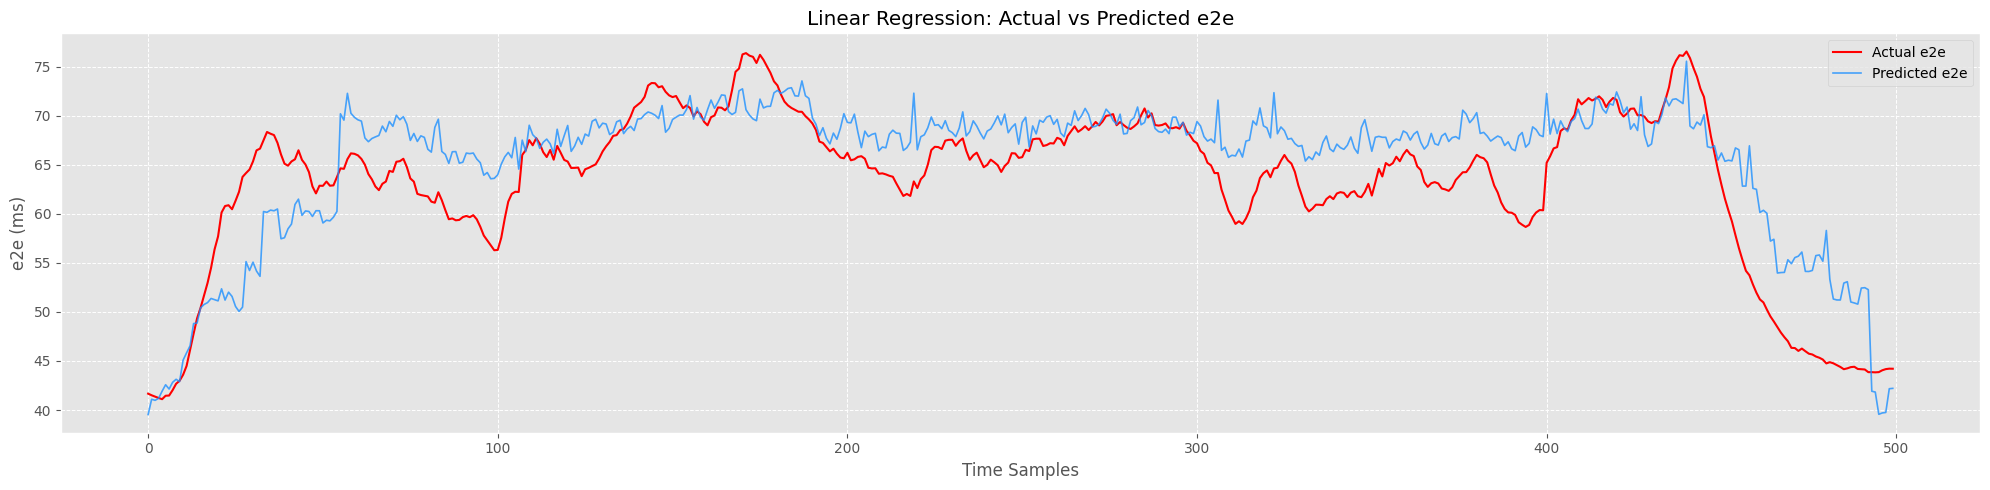

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = reg.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("Linear Regression: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


## Tree Based Models

### Random forrest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_scaled)
y_pred = rf.predict(X_val_scaled)

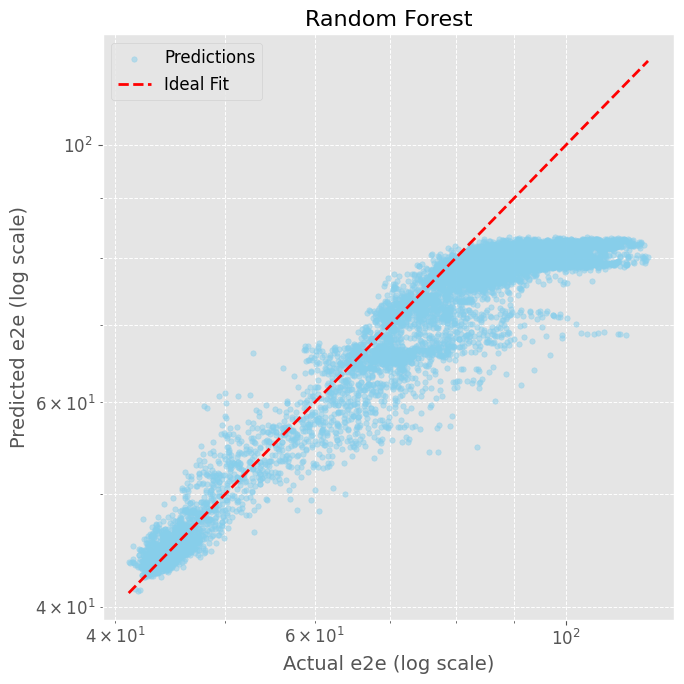

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = rf.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("Random Forest")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["RandForest"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  8.2768
MSE:  123.4175
RMSE: 11.1093
R²:   0.6543


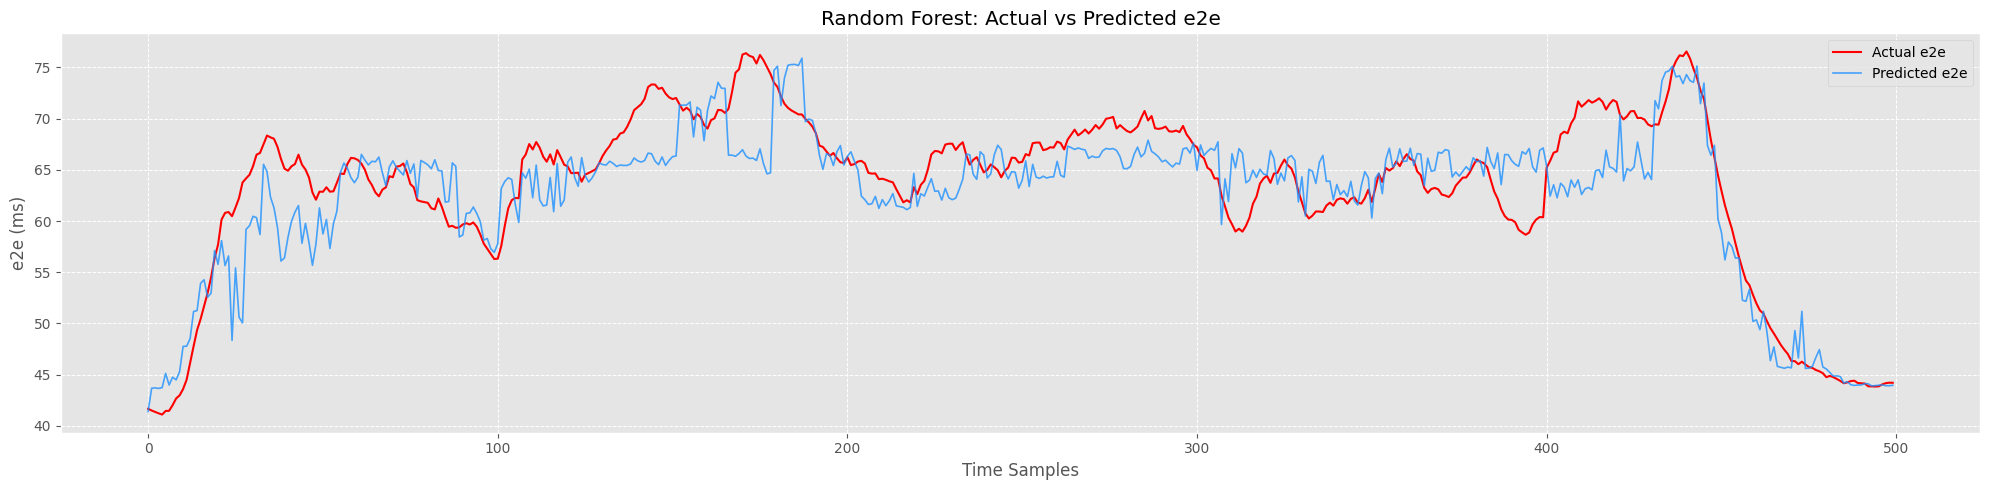

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = rf.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("Random Forest: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


### Gradient Boosting

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
xgb.fit(X_train_scaled, y_train_scaled)
y_pred = xgb.predict(X_val_scaled)


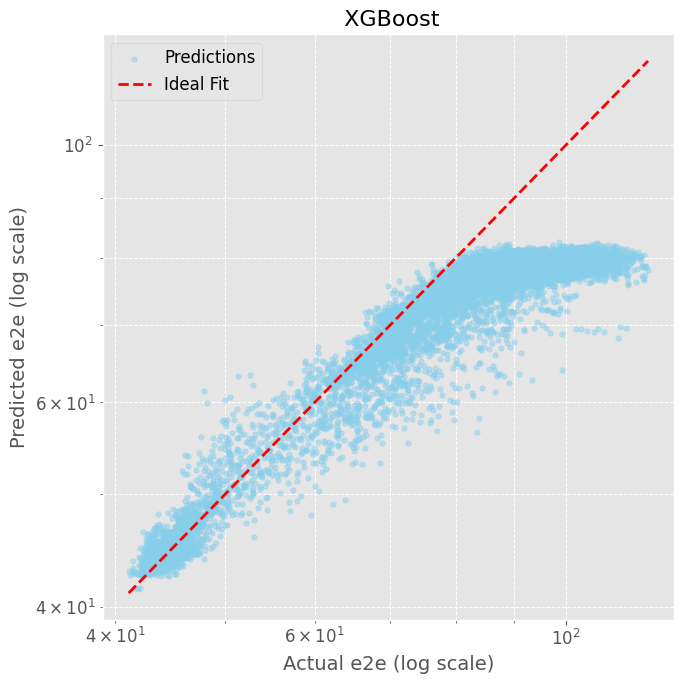

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = xgb.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title(" XGBoost")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["XGBoost"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  9.2141
MSE:  147.8660
RMSE: 12.1600
R²:   0.5858


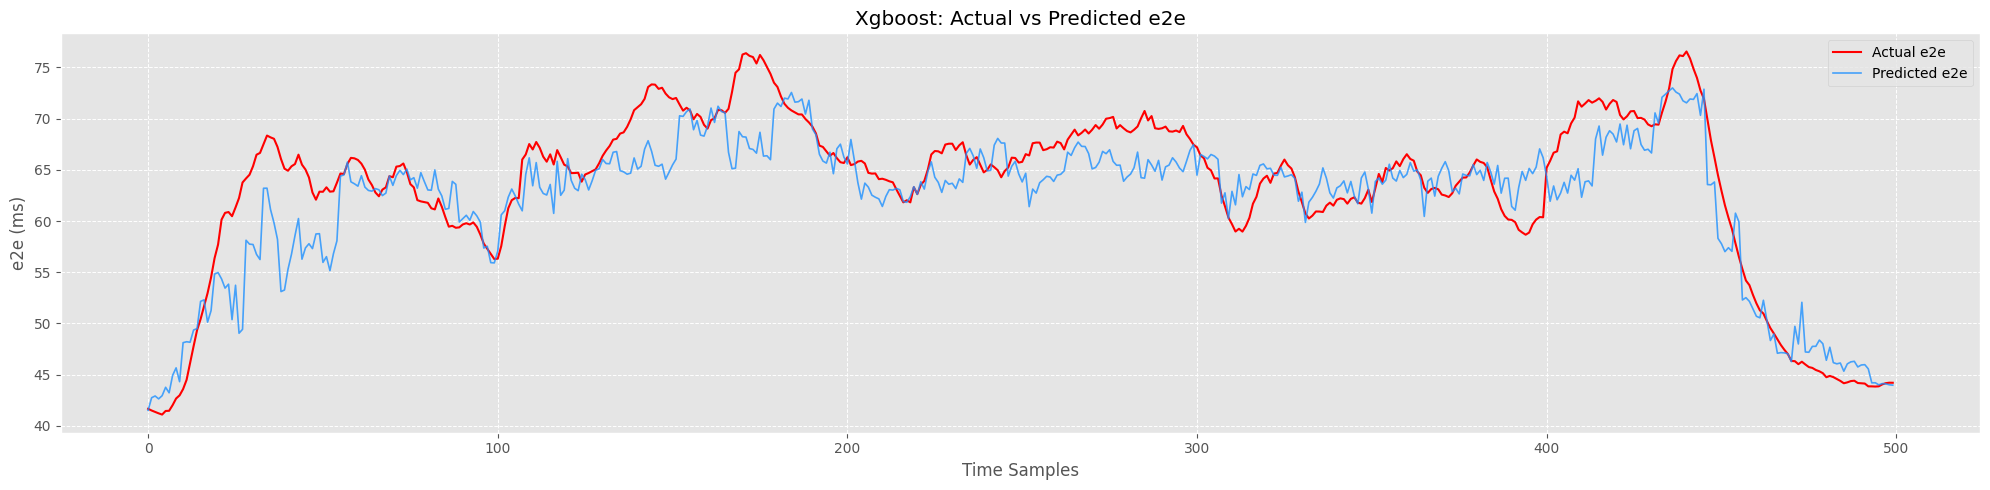

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = xgb.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("Xgboost: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


## Neural Networks (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train_scaled)
y_pred = mlp.predict(X_val_scaled)

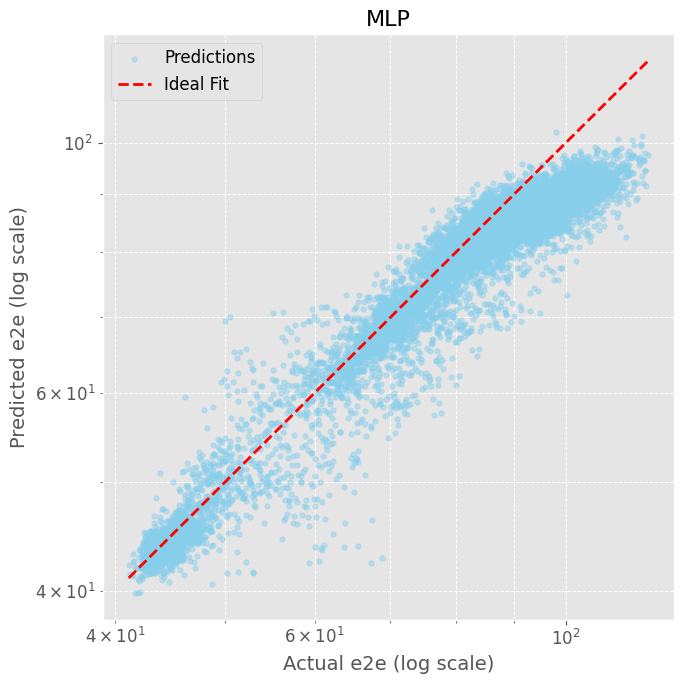

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = mlp.predict(X_val_scaled)

y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))

#zoom = slice(1000, 1500)
zoom = slice(None)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(7, 7))
plt.scatter(y_true_zoom, y_pred_zoom, alpha=0.5, color="skyblue", s=15, label="Predictions")
plt.plot([y_true_zoom.min(), y_true_zoom.max()],
         [y_true_zoom.min(), y_true_zoom.max()],
         "r--", linewidth=2, label="Ideal Fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Actual e2e (log scale)")
plt.ylabel("Predicted e2e (log scale)")
plt.title("MLP")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.tight_layout()
fig = plt.gcf()
ax = plt.gca()

plt.show()

plots["MLP"] = (fig, ax)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true_zoom, y_pred_zoom)
mse = mean_squared_error(y_true_zoom, y_pred_zoom)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_zoom, y_pred_zoom)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  4.7976
MSE:  44.2761
RMSE: 6.6540
R²:   0.8760


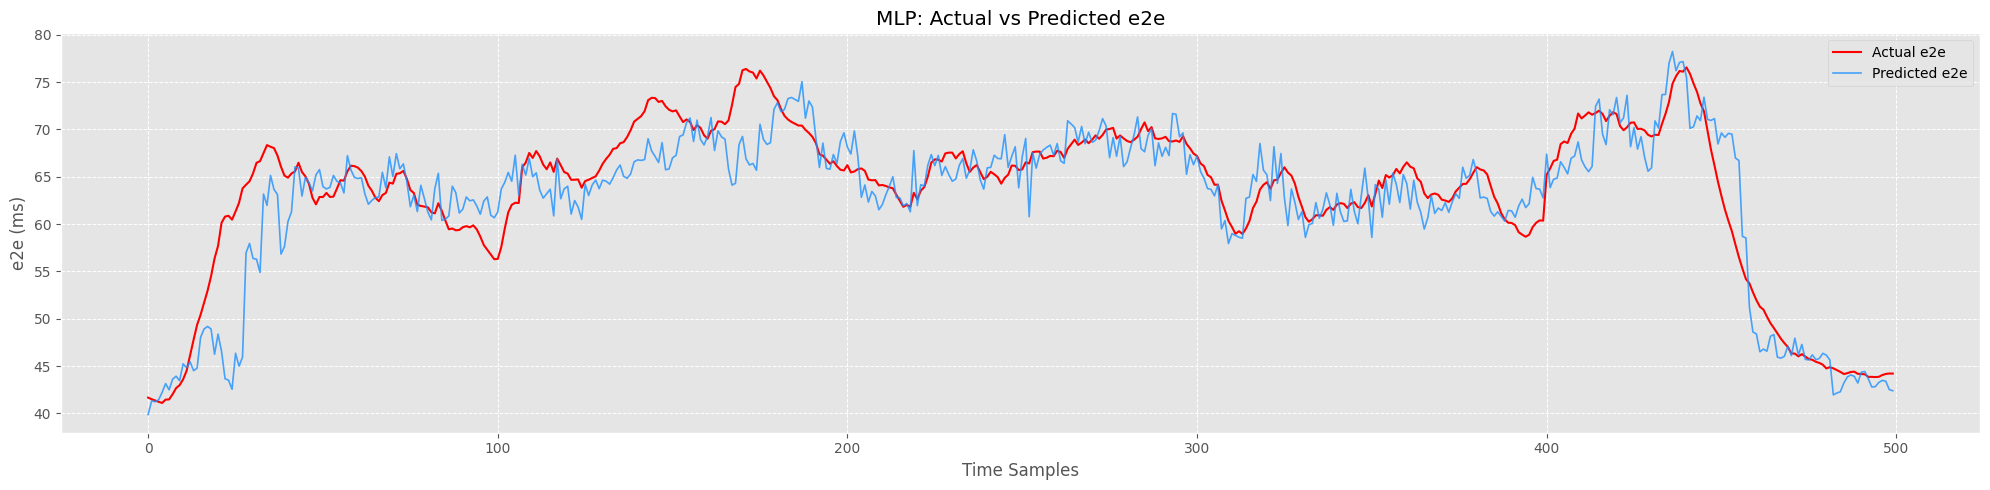

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_val_pred_scaled = mlp.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_original = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))


zoom = slice(1000, 1500)
y_true_zoom = y_val_original[zoom]
y_pred_zoom = y_val_pred[zoom]

plt.figure(figsize=(20, 5))
plt.plot(y_true_zoom, label="Actual e2e", color="red", linewidth=1.5)
plt.plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)

plt.title("MLP: Actual vs Predicted e2e")
plt.xlabel("Time Samples")
plt.ylabel("e2e (ms)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


# Comparison

In [ ]:
from tabulate import tabulate

def add_metrics(label: str, metrics_str: str):
    metrics = {}
    for line in metrics_str.strip().splitlines():
        if ":" in line:
            key, val = line.split(":")
            metrics[key.strip()] = float(val.strip())
    results[label] = metrics

results = {}

In [ ]:
headers = ["Model"] + list(next(iter(results.values())).keys())
table = [[label] + [metrics[k] for k in headers[1:]] for label, metrics in results.items()]

print(tabulate(table, headers=headers, floatfmt=".4f"))

Model            MAE       MSE     RMSE      R²
------------  ------  --------  -------  ------
Linear Reg    8.1446  105.1481  10.2542  0.7054
Rand Forrest  8.2768  123.4175  11.1093  0.6543
XGboost       9.2141  147.8660  12.1600  0.5858
MLP           4.7976   44.2761   6.6540  0.8760
CNN           3.3155   20.2751   4.5028  0.9432
GRU           3.5778   25.8832   5.0875  0.9275
LSTM          3.3296   26.2273   5.1213  0.9265
CNN+LSTM      2.9105   20.1610   4.4901  0.9435


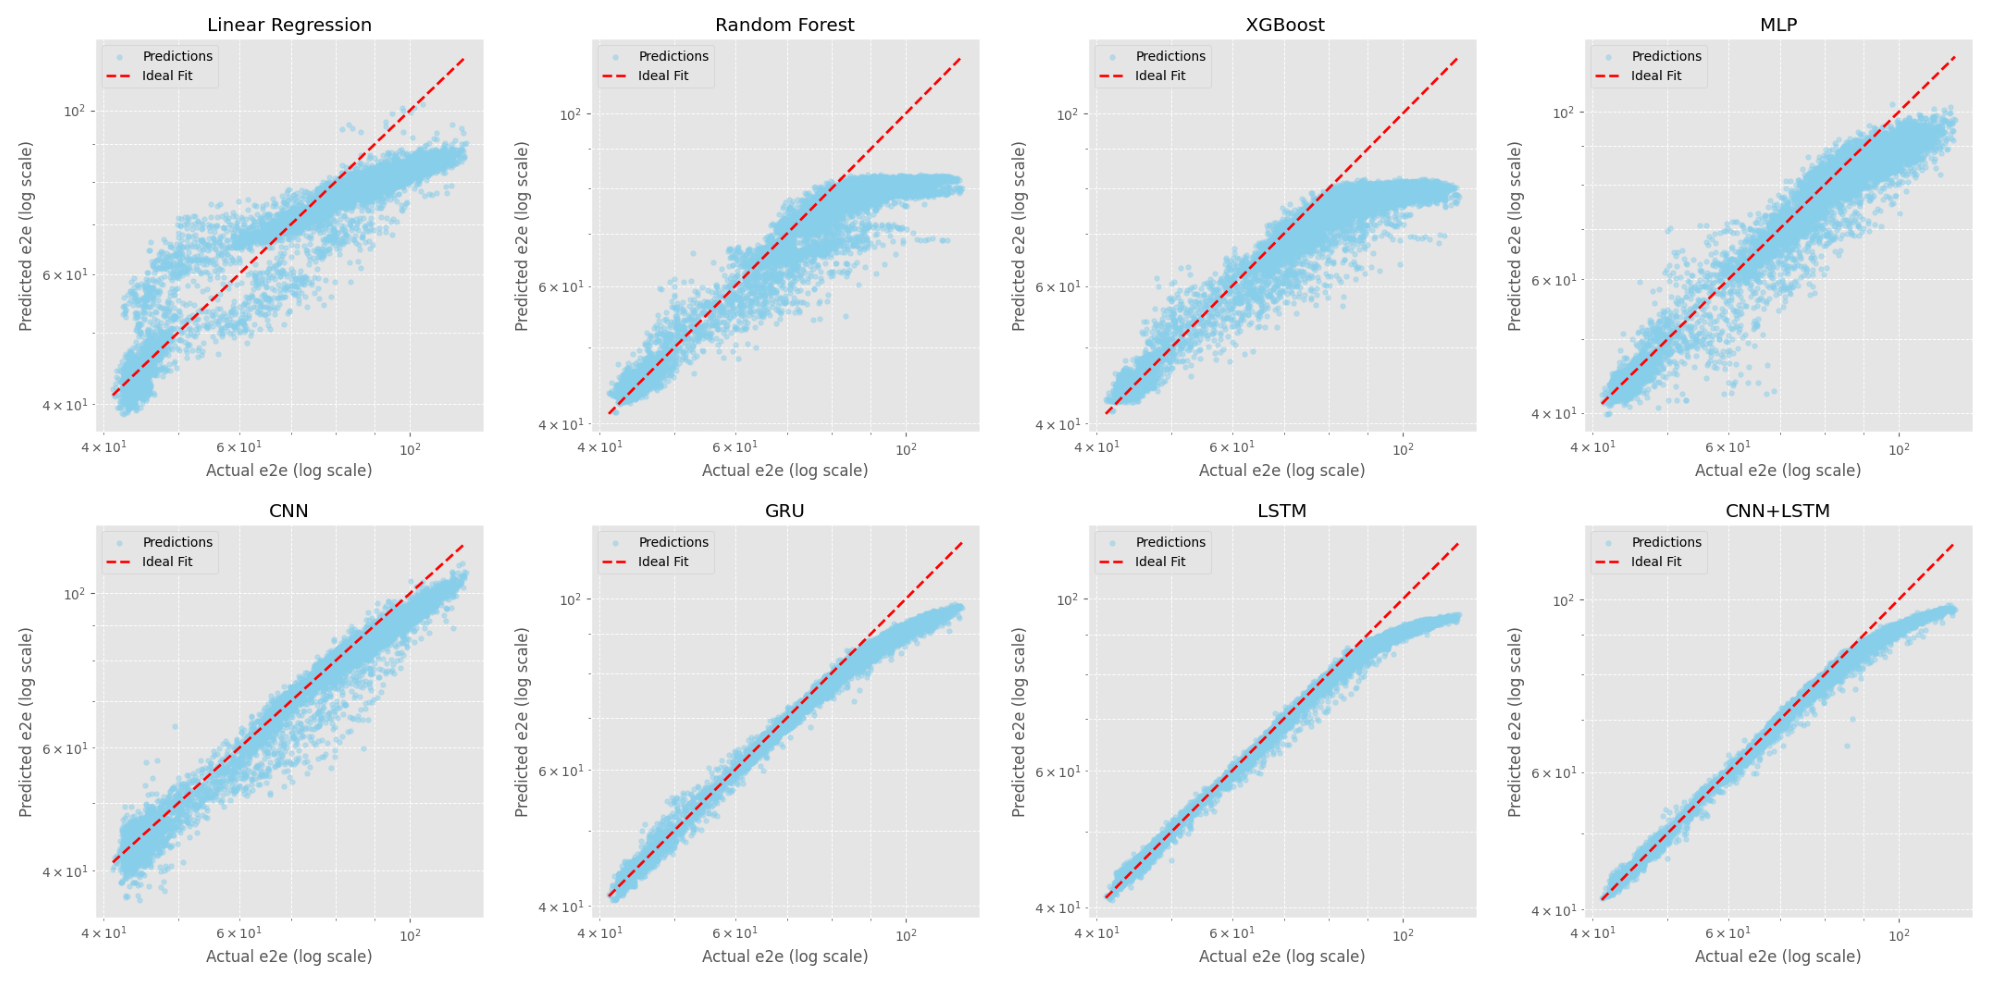

In [ ]:
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

labels = ['LinearReg', 'RandForest', 'XGBoost', 'MLP',
          'CNN', 'GRU', 'LSTM', 'CNN+LSTM']


grid_fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, label in enumerate(labels):
    fig, ax = plots[label]

    fig.set_size_inches(5, 5)

    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100, bbox_inches="tight")
    buf.seek(0)

    img = Image.open(buf)
    axes[i].imshow(img)
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# Graphs

In [ ]:
def my_plot(df, to_plot, zoom=slice(None), height=5):
    if isinstance(zoom, tuple):
        zoom = slice(*zoom)

    fig, ax = plt.subplots(figsize=(20, len(to_plot)*height), nrows=len(to_plot))

    if len(to_plot) == 1:
        ax = [ax]

    for i, col in enumerate(to_plot):
        df[col][zoom].plot(ax=ax[i])
        ax[i].set_xlabel(col, fontsize=20)

    plt.tight_layout()
    plt.show()

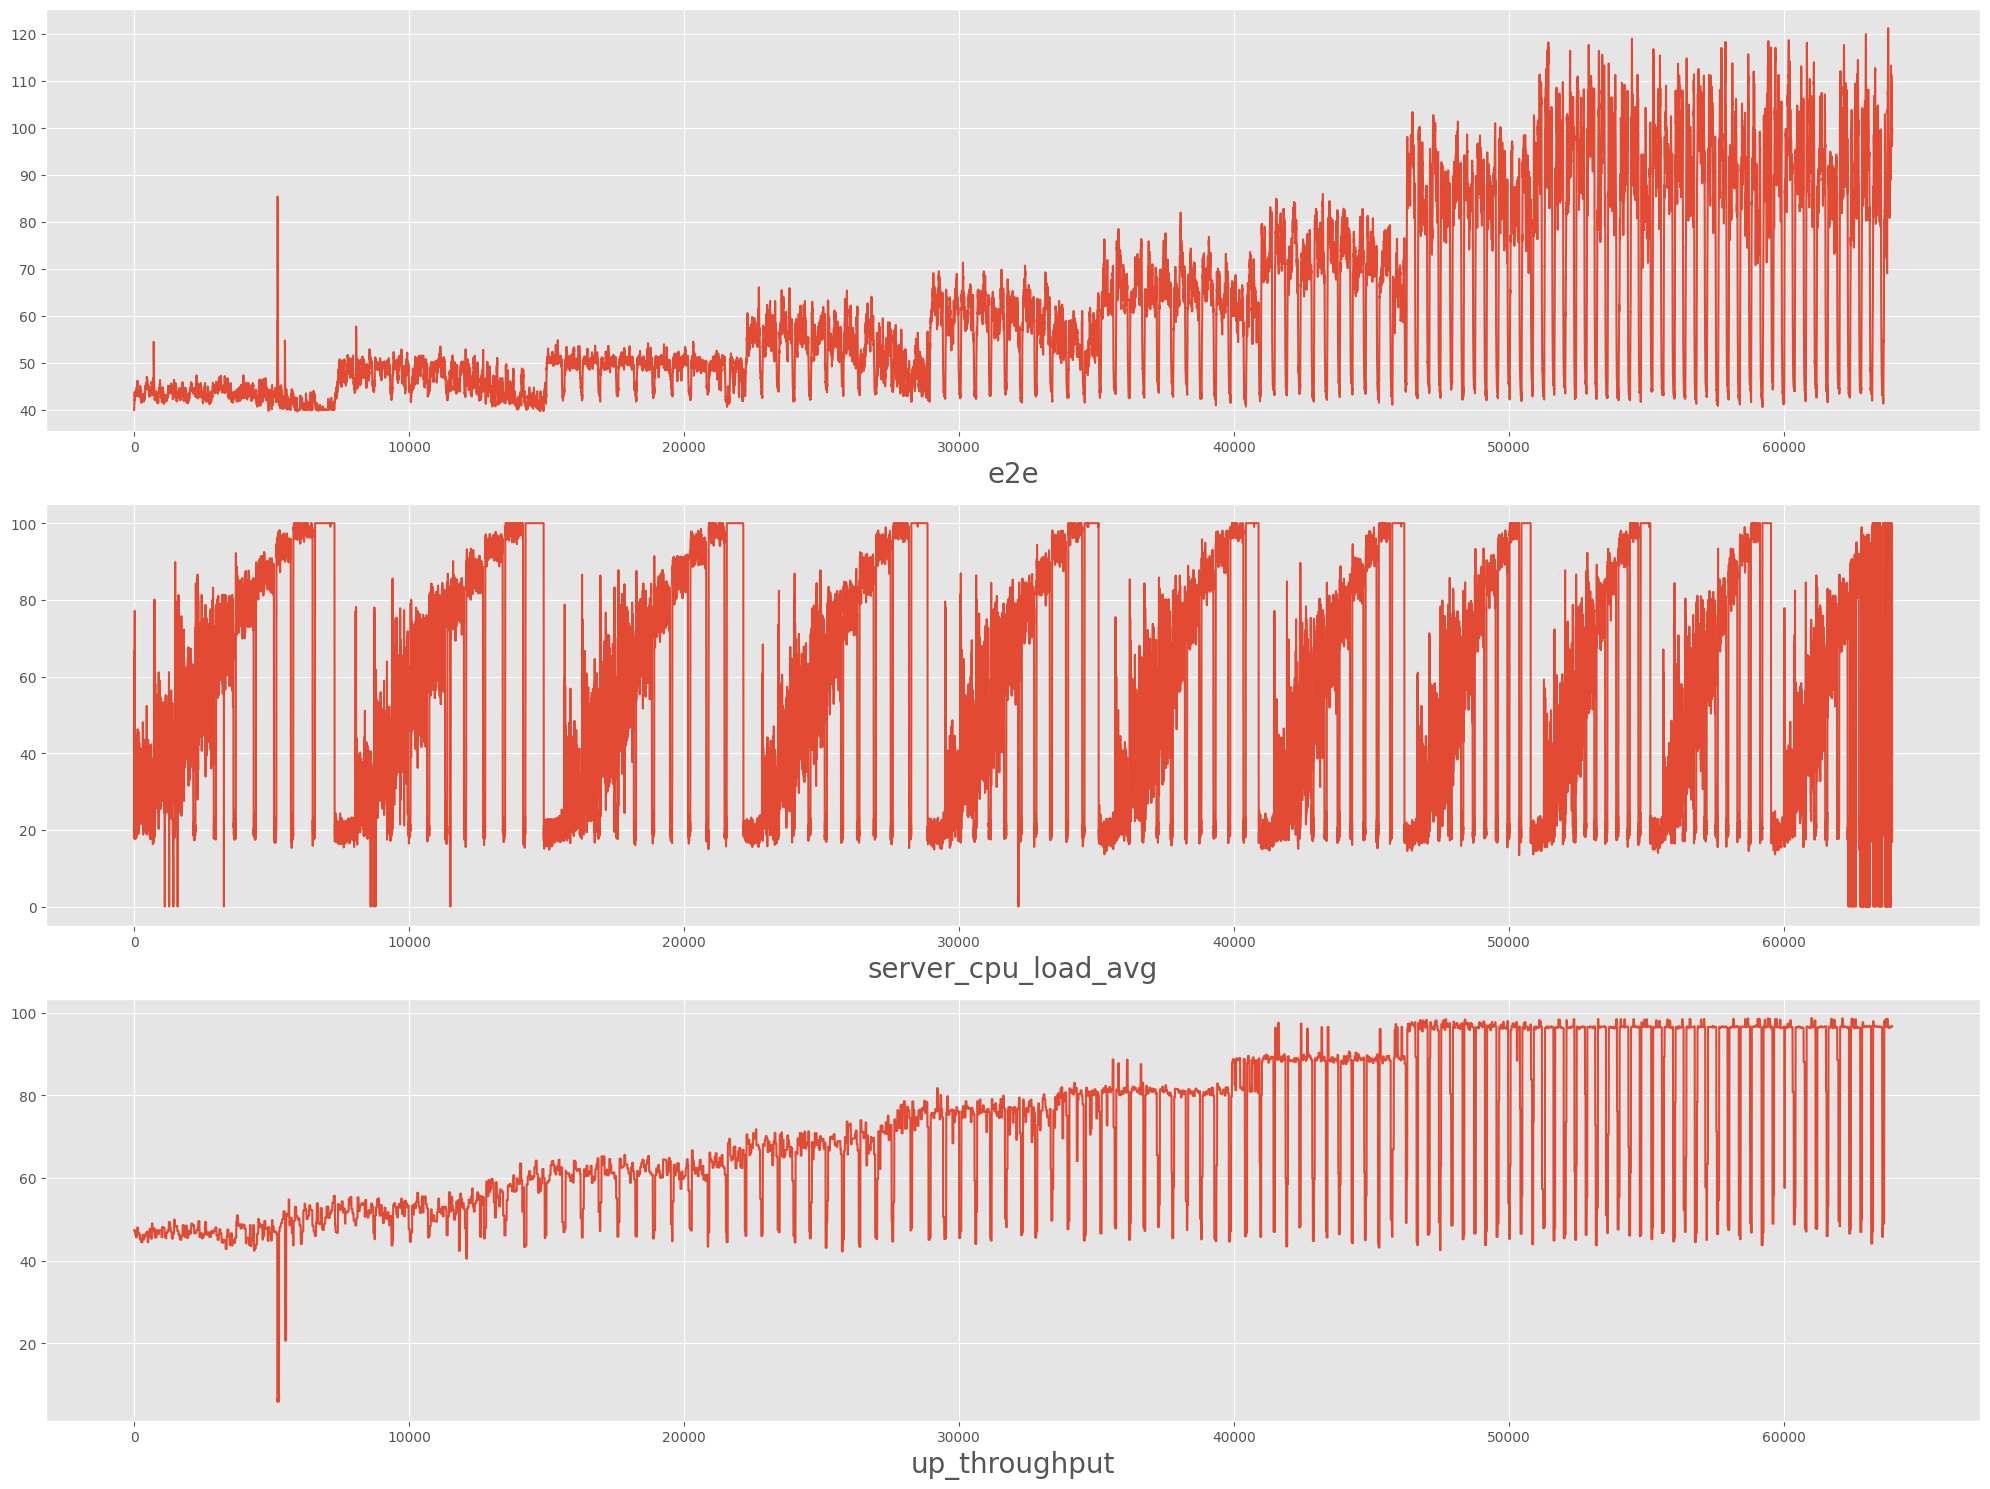

In [ ]:
my_plot(df, ['e2e', 'server_cpu_load_avg', 'up_throughput'], zoom=slice(None), height=5)

/tmp/ipython-input-1697652573.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(fontsize=legend_size)
/tmp/ipython-input-1697652573.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(fontsize=legend_size)
/tmp/ipython-input-1697652573.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend(fontsize=legend_size)
/tmp/ipython-input-1697652573.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[3].legend(fontsize=legend_size)


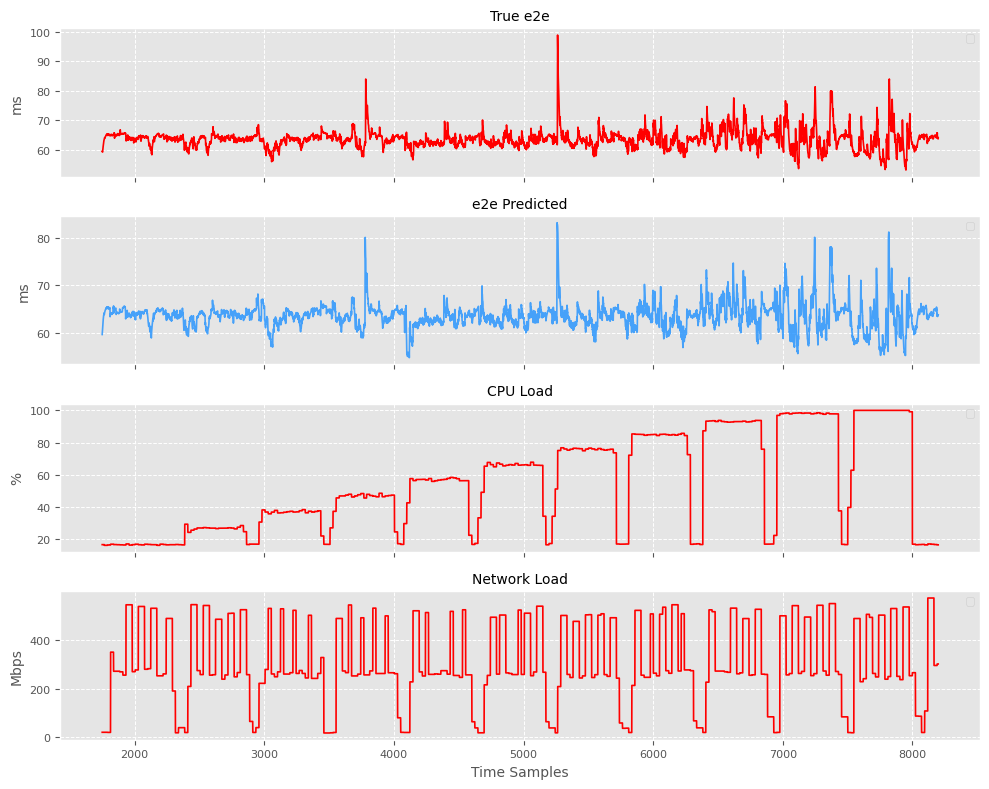

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_val = pd.read_csv('/content/drive/MyDrive/LatencyPrediction/graph.csv')

# Parameters for fonts
title_size  = 10
label_size  = 10
tick_size   = 8
legend_size = 8

#zoom = slice(None)
zoom = slice(1750, 8200)

y_true_zoom = df_val['e2e'].iloc[zoom]
y_pred_zoom = df_val['e2e_pred'].iloc[zoom]
cpu_zoom = df_val['server_cpu_avg'].iloc[zoom]
net_zoom = df_val['r2_to_r1_recv(Mbps)'].iloc[zoom]

fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(10, 8),
    sharex=True
)


axes[0].plot(y_true_zoom, color="red", linewidth=1.2)
#axes[0].plot(y_pred_zoom, label="Predicted e2e", color="dodgerblue", alpha=0.8, linewidth=1.2)
axes[0].set_ylabel("ms", fontsize=label_size)
axes[0].set_title("True e2e", fontsize=title_size)
axes[0].legend(fontsize=legend_size)
axes[0].tick_params(axis='both', labelsize=tick_size)
axes[0].grid(True, linestyle="--", linewidth=0.7)

axes[1].plot(y_pred_zoom, color="dodgerblue", alpha=0.8, linewidth=1.2)
axes[1].set_ylabel("ms", fontsize=label_size)
axes[1].set_title("e2e Predicted", fontsize=title_size)
axes[1].legend(fontsize=legend_size)
axes[1].tick_params(axis='both', labelsize=tick_size)
axes[1].grid(True, linestyle="--", linewidth=0.7)

axes[2].plot(cpu_zoom, color="red", linewidth=1.2)
axes[2].set_ylabel("%", fontsize=label_size)
axes[2].set_title("CPU Load", fontsize=title_size)
axes[2].legend(fontsize=legend_size)
axes[2].tick_params(axis='both', labelsize=tick_size)
axes[2].grid(True, linestyle="--", linewidth=0.7)

axes[3].plot(net_zoom, color="red", linewidth=1.2)
axes[3].set_xlabel("Time Samples", fontsize=label_size)
axes[3].set_ylabel("Mbps", fontsize=label_size)
axes[3].set_title("Network Load", fontsize=title_size)
axes[3].legend(fontsize=legend_size)
axes[3].tick_params(axis='both', labelsize=tick_size)
axes[3].grid(True, linestyle="--", linewidth=0.7)

plt.tight_layout()
plt.show()


In [ ]:
df_merged = pd.read_csv(folder_path+'/eda_merged.csv')
df_merged.drop(columns=['time', 'cpu', 'network', 'e2e_is_na', 'e2e_is_not_na', 'e2e_span'], inplace=True)

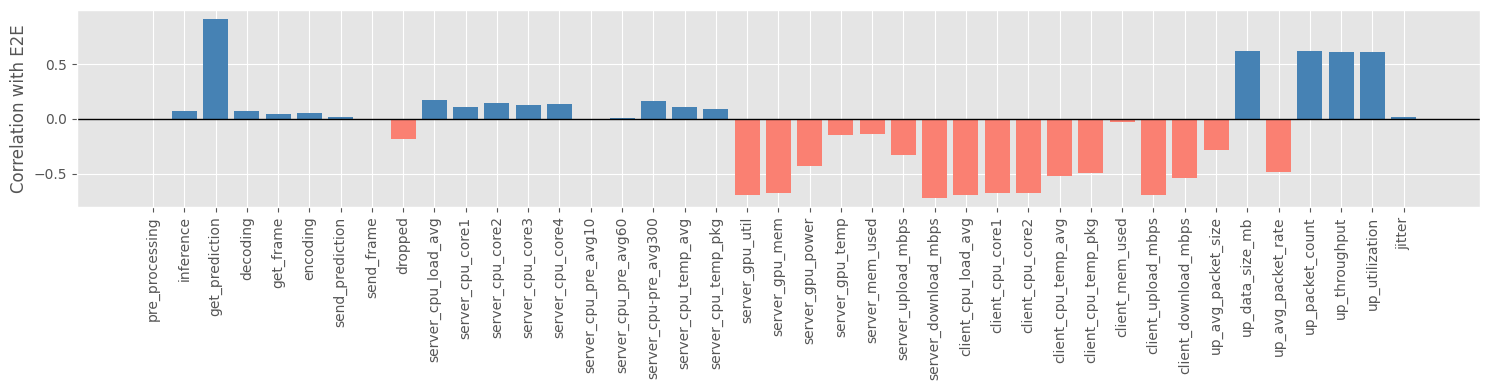

In [ ]:
import matplotlib.pyplot as plt

corr_with_e2e = df_merged.corr()['e2e'].drop('e2e') 

colors = ["steelblue" if v > 0 else "salmon" for v in corr_with_e2e]

plt.figure(figsize=(15, 4))
plt.bar(corr_with_e2e.index, corr_with_e2e.values, color=colors)
plt.axhline(0, color="black", linewidth=1) 

plt.xticks(rotation=90)
plt.ylabel("Correlation with E2E")
plt.tight_layout()
plt.show()